Začneme tim, že načteme všechny potřebné baličky, a načteme všechny soubory. Ligandy Cytochromu a Drugbanku leži v promennych <b>cyto_ligands</b> a <b>drugs</b> resp. Do proměnnych <b>cyto_ligands_maccs</b> a <b>drugs_maccs</b> uložime hodnoty MACCS.


In [2]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
import pandas as pd
import seaborn as sns
import csv

with open('CHEMBL26-chembl_26_activity.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    cyto_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('drugbank.sdf')
drugs = [m for m in suppl if m]

cyto_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in cyto_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

RDKit ERROR: [16:04:37] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [16:04:37] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [16:04:37] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [16:04:37] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [16:04:37] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [16:04:37] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [16:04:37] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [16:04:37] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [16:04:37] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [16:04:37] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [16:04:37] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [16:04:37] Can't kek

RDKit ERROR: [16:04:38] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: 
RDKit ERROR: [16:04:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9 10
RDKit ERROR: 
RDKit ERROR: [16:04:38] ERROR: Could not sanitize molecule ending on line 442989
RDKit ERROR: [16:04:38] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9 10
RDKit ERROR: 
RDKit ERROR: [16:04:38] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [16:04:38] ERROR: Could not sanitize molecule ending on line 447465
RDKit ERROR: [16:04:38] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [16:04:38] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [16:04:38] ERROR: Could not sanitize molecule ending on line 466177
RDKit ERROR: [16:04:38] ERROR: Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [16:04:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERR

RDKit ERROR: [16:04:38] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [16:04:39] Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [16:04:39] ERROR: Could not sanitize molecule ending on line 995692
RDKit ERROR: [16:04:39] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [16:04:39] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [16:04:39] ERROR: Could not sanitize molecule ending on line 1151592


Ted' použijeme funkci <b>similarity_search()</b> z cvika, a podivame se na vysledky.



In [3]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True)

hits = similarity_search(cyto_ligands_maccs[0], drugs_maccs)
hits

[]

Takže. Nemame žadné podobne molekuly pro standartní cutoff. Podívame se na rozdělení podobnosti pro MACCS kliči.

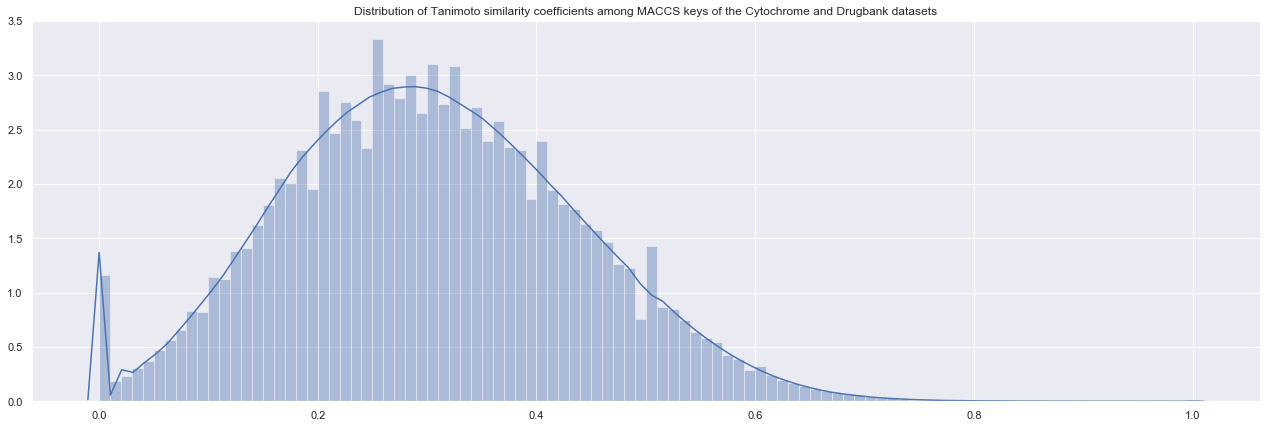

In [4]:
sims = []
for lig in cyto_ligands_maccs:
    for dr in drugs_maccs:
        sims.append(DataStructs.TanimotoSimilarity(lig, dr))


sns.set(rc={'figure.figsize':(22, 7)})
with sns.axes_style("darkgrid"):
    p = sns.distplot(sims, bins=100)
    p.set_title(f"Distribution of Tanimoto similarity coefficients among MACCS keys of the Cytochrome and Drugbank datasets")

Ted' podivame se na tu samou metriku, jen pro ECFP. Vidime, že take nemá žadny hit pro standartní cutoff. Opakujeme vizualizace distribuci, stejne jako v minulé buňce.

In [5]:
cyto_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in cyto_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]
hits = similarity_search(cyto_ligands_ecfp[0], drugs_ecfp)

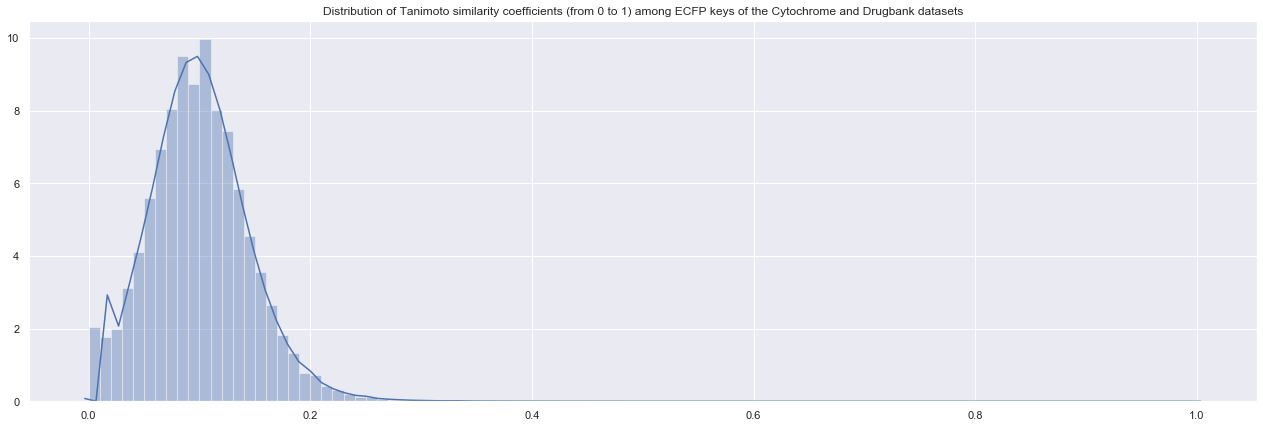

In [6]:
thres = 0
sims_ecfp = []
for lig in cyto_ligands_ecfp:
    for dr in drugs_ecfp:
        sim = DataStructs.TanimotoSimilarity(lig, dr)
        if sim >= thres:
              sims_ecfp.append(sim)


sns.set(rc={'figure.figsize':(22, 7)})
with sns.axes_style("darkgrid"):
    p = sns.distplot(sims_ecfp, bins=100)
    p.set_title(f"Distribution of Tanimoto similarity coefficients (from {thres} to 1) among ECFP keys of the Cytochrome and Drugbank datasets")

Vidime, že v připadě datasetů Drugbank a Cytochromů, jsou tam malo podobnych latek. Ale ukazuje tento plot distribuce podobnosti všech latek, mezi všemi latkama Drugbanku. Zkusime vizualizuvat distribuci pruměru podobnosti pro každou latku datasetu Cytochromu.

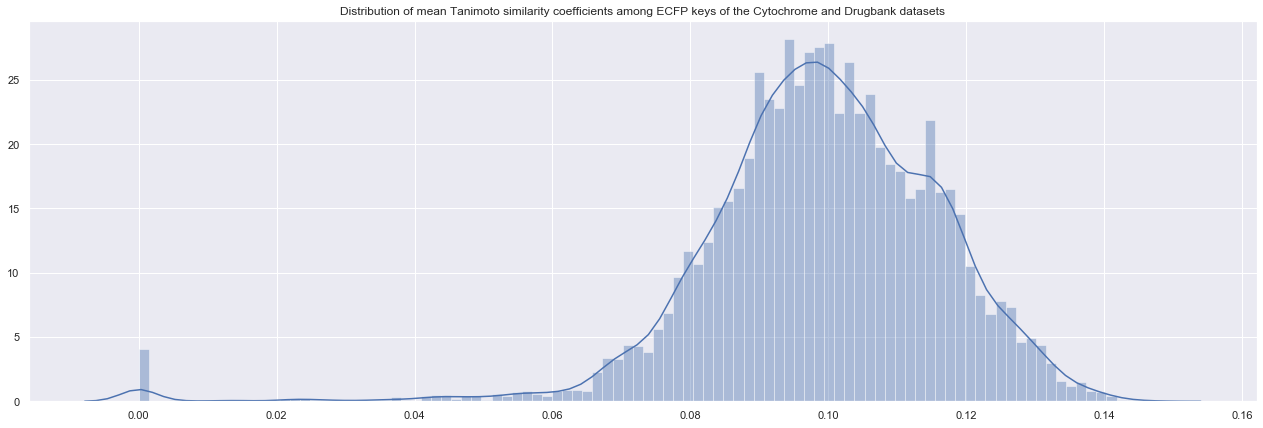

In [7]:
sims_mean = []
       
for lig in cyto_ligands_ecfp:
    scores = []
    for dr in drugs_ecfp:
        scores.append(DataStructs.TanimotoSimilarity(lig, dr))
    sims_mean.append(sum(scores)/len(scores))


sns.set(rc={'figure.figsize':(22, 7)})
with sns.axes_style("darkgrid"):
    p = sns.distplot(sims_mean, bins=100)
    p.set_title(f"Distribution of mean Tanimoto similarity coefficients among ECFP keys of the Cytochrome and Drugbank datasets")

Dobře, je to zajimava statistika. Vidime, že celkem dataset Cytochromu malo podobny datasetu Drugbank. Ted' podivame se na podobné latky, a jich počet.

In [8]:
cyto_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(cyto_ligands_ecfp)] 

Do proměnné <b>cyto_ligand_hits</b> uložime všechny latky, ktere jsou podobne. Do proměnné <b>cyto_ligand_hits_nofull</b> uložime všechny latky, ktere mají Tanimoto koeficient meně než 1. 





In [9]:
cyto_ligand_hits = [hit for hit in cyto_ligands_queries if hit[1]]
cyto_ligand_hits_no_full = []

for i, lis in cyto_ligand_hits:
    no_match = []
    for el in lis:
        if el[1] != 1.0:
            no_match.append(el)
    if len(no_match) > 0:
        cyto_ligand_hits_no_full.append((i, no_match))
len(cyto_ligands_queries), len(cyto_ligand_hits), len(cyto_ligand_hits_no_full)


(13692, 1742, 484)

A ted' vidime, že máme 1742 (12.72%) latek z datasetu Cytochromu (včetně uplných matchů) a také 484 (3.53%) latek podobnych, ale není uplně. Podivame se na latky. Pod indexem 12 v <b>cyto_ligand_hits</b> leži latka, ktera je podobna na 3 molekuly z Drugbanku.

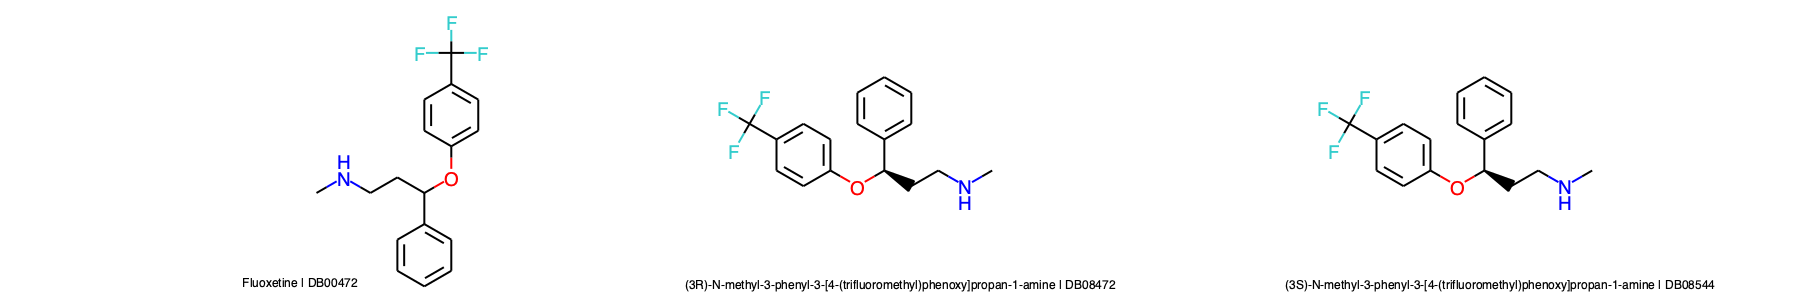

In [10]:
hit_mols1 = [drugs[index] for index, similarity in cyto_ligand_hits[12][1]]
Draw.MolsToGridImage(hit_mols1, molsPerRow=3, subImgSize=(600,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols1])


Takže, je to Fluoxetin (obchodní značka Prozac, pod kterou ji uvedla na trh americká firma Eli Lilly). Fluoxetin je lék používaný zejména při léčení deprese. Citata z [Wiki](https://en.wikipedia.org/wiki/Fluoxetine):

<b>"Fluoxetine and norfluoxetine inhibit many isozymes of the cytochrome P450 system that are involved in drug metabolism."</b>

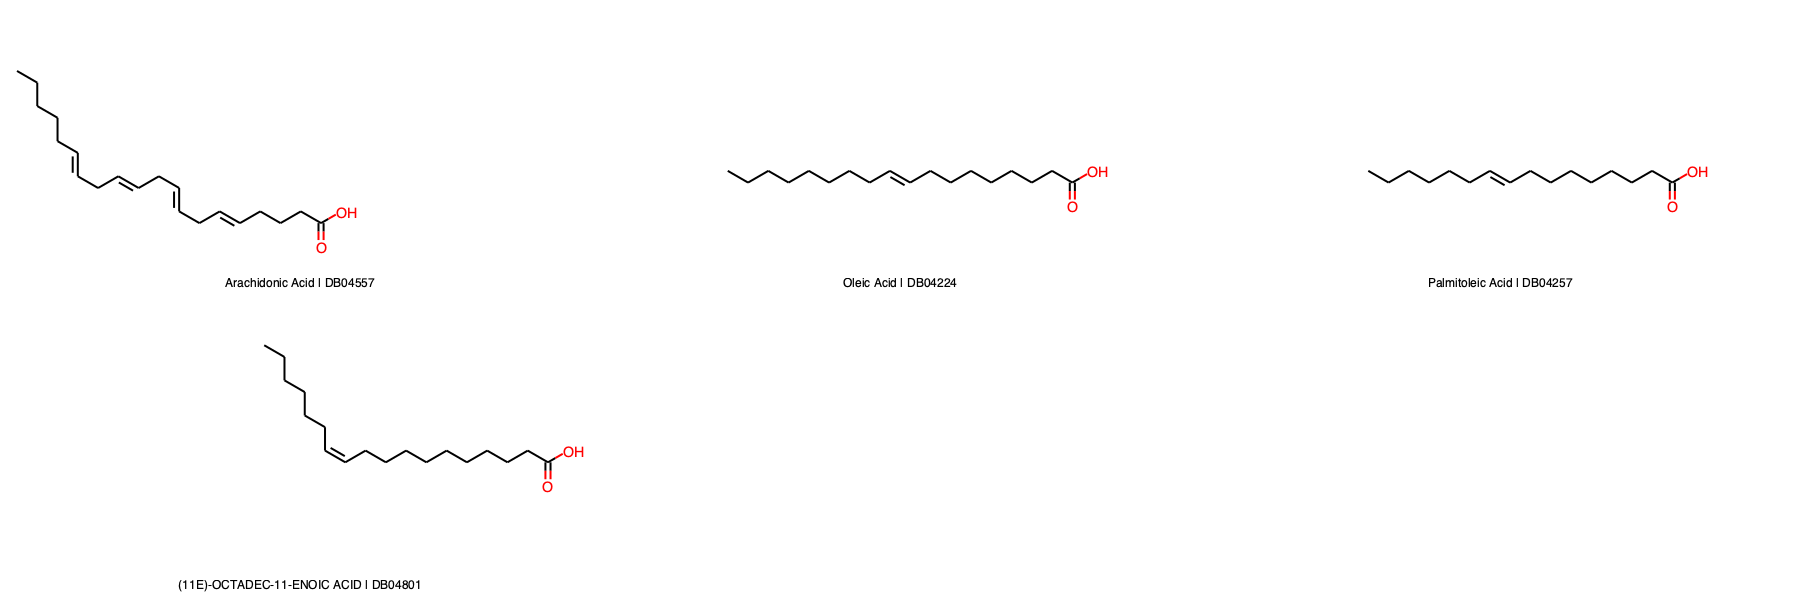

In [11]:
hit_mols2 = [drugs[index] for index, similarity in cyto_ligand_hits_no_full[117][1]]
Draw.MolsToGridImage(hit_mols2, molsPerRow=3, subImgSize=(600,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols2])

Tady máme nenasycené mastné kyseliny. Proč? Znovu [citata:](https://www.sciencedirect.com/science/article/pii/S157096391000258X)

<b>Cytochrome P450 (CYP)-dependent metabolites of arachidonic acid (AA), such as epoxyeicosatrienoic acids and 20-hydroxyeicosatetraenoic acid, serve as second messengers of various hormones and growth factors and play pivotal roles in the regulation of vascular, renal and cardiac function.</b>

Dobře. Ted' podivame se na všichny hity.

/Users/hanchary/miniconda3/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


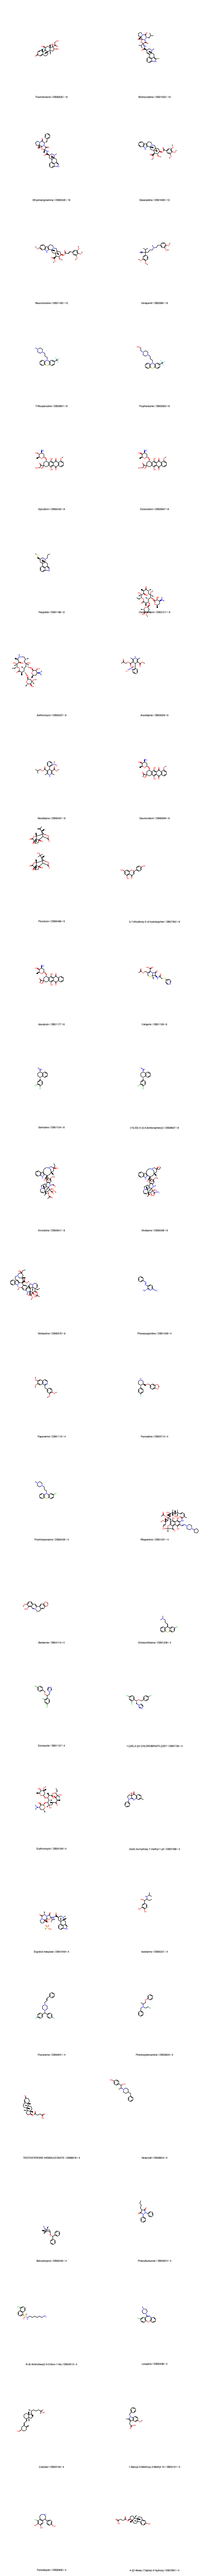

In [12]:
drugs_hitcounts = {}
for ligand, hits in cyto_ligand_hits_no_full:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
ordered_drugs_hitcounts = sorted(drugs_hitcounts.keys(), key=lambda x: drugs_hitcounts[x], reverse=True)

hit_mols = [drugs[i] for i in ordered_drugs_hitcounts]
Draw.MolsToGridImage(hit_mols, molsPerRow=2, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30], # just cut off too long IUPAC stuff
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

Takže, tady máme Triamcinolon (12 hitů), Bromocriptine (10 hitů) a Dihydroergotamine (10 hitů). Jsou to leky, existujici na trhu, a jsou v datasetů ligandů Cytochromu, protože Cytochrom P450 je hlavní cestou vylučování léčiv a významně se podílí na metabolismu kortikosteroidů.

A ted' najdemé maximalně diverzní latky.

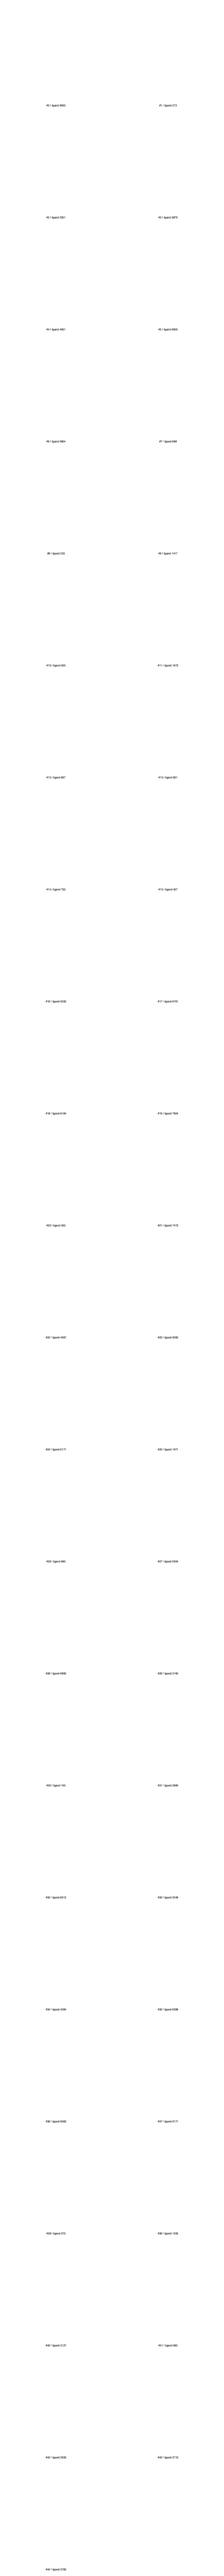

In [13]:
def distance_function(index1, index2, *args, cheminformaticsfingerprints=cyto_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(cheminformaticsfingerprints[index1],
                                                 cheminformaticsfingerprints[index2],
                                                 metric=metric)
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(cyto_ligands), 45))

Draw.MolsToGridImage([cyto_ligands[i] for i in picked], molsPerRow=2, subImgSize=(500,500),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])

A tady nevím, v čem je problem. Prostě naprintuje prazdné obrazovky